### Множественная линейная регрессия

Множественная регрессия с одной переменной

In [17]:
import datetime
 
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import plotly
import statsmodels
import statsmodels.tsa.arima_process

import seaborn as sns
sns.set()

In [13]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [52]:
data_for_model = pd.read_csv('Test_1.csv', sep=';', engine='python', encoding='Windows 1251', decimal= ',')
data_for_model.head()

,City,Date,Регистрации_organic,Переходы_paid,Регистрации_paid,T,RRR,sss,Orders_all,Orders_with_coupon,Num_of_OOH,OTS,Reach,Google Trends,Яндекс Вордстат,TVR
0,Москва,01.01.2018,88,0,16,0.9125,0.0,0.0,17100,0,0,0,0.0,NaN,NaN,0.0
1,Москва,02.01.2018,16,0,0,1.9375,0.0,0.0,11010,0,0,0,0.0,NaN,NaN,0.0
2,Москва,03.01.2018,8,0,0,2.3875,0.6,0.0,11040,0,0,0,0.0,NaN,NaN,0.0
3,Москва,04.01.2018,0,0,8,2.0375,0.0,0.0,11190,0,0,0,0.0,NaN,NaN,0.0
4,Москва,07.01.2018,0,0,0,1.8250,1.3,0.0,13260,0,0,0,0.0,NaN,NaN,0.0


In [35]:
data_for_model['Date']= pd.to_datetime(data_for_model['Date'])
print(data_for_model['Date'].max())
print(data_for_model['Date'].min())

2020-12-06 00:00:00
2018-01-01 00:00:00


In [47]:
data_for_model.info()

,City,Date,Регистрации_organic,Переходы_paid,Регистрации_paid,T,RRR,sss,Orders_all,Orders_with_coupon,Num_of_OOH,OTS,Reach,Google Trends,Яндекс Вордстат,TVR
0,Москва,2018-01-01,88,0,16,0.9125,0.0,0.0,17100,0,0,0,0.0,NaN,NaN,0.0
1,Москва,2018-02-01,16,0,0,1.9375,0.0,0.0,11010,0,0,0,0.0,NaN,NaN,0.0
2,Москва,2018-03-01,8,0,0,2.3875,0.6,0.0,11040,0,0,0,0.0,NaN,NaN,0.0
3,Москва,2018-04-01,0,0,8,2.0375,0.0,0.0,11190,0,0,0,0.0,NaN,NaN,0.0
4,Москва,2018-07-01,0,0,0,1.8250,1.3,0.0,13260,0,0,0,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5757,Тюмень,2020-02-07,584,6144,3352,0.0000,0.0,0.0,17040,7425,0,0,0.0,42.34,2389.763,0.0
5758,Ульяновск,2020-02-07,168,8744,776,0.0000,0.0,0.0,22575,2700,55,0,0.0,42.34,2389.763,0.0
5759,Уфа,2020-02-07,536,45336,2984,0.0000,0.0,0.0,48105,14175,57,0,0.0,42.34,2389.763,0.0
5760,Челябинск,2020-02-07,704,36032,2776,0.0000,0.0,0.0,91815,31140,60,0,0.0,42.34,2389.763,0.0


In [50]:
data_for_model.corr()

,Регистрации_organic,Переходы_paid,Регистрации_paid,T,RRR,sss,Orders_all,Orders_with_coupon,Num_of_OOH,OTS,Reach,Google Trends,Яндекс Вордстат,TVR
Регистрации_organic,1.000000,0.457891,0.742553,0.089286,0.177191,-0.054238,0.800914,0.194601,0.035999,0.559281,0.706713,0.243933,0.165467,0.132622
Переходы_paid,0.457891,1.000000,0.792843,0.091048,0.139323,-0.031226,0.713045,0.427744,0.397048,0.597859,0.638828,-0.087099,-0.121202,0.142030
Регистрации_paid,0.742553,0.792843,1.000000,0.107978,0.207318,-0.073600,0.839706,0.374599,0.324860,0.585778,0.730246,0.124181,0.027728,0.147498
T,0.089286,0.091048,0.107978,1.000000,0.054645,-0.468785,0.007695,-0.009446,0.237664,-0.073091,-0.058619,-0.025425,-0.344182,-0.312220
RRR,0.177191,0.139323,0.207318,0.054645,1.000000,-0.008981,0.148324,0.079898,0.103241,0.095975,0.108730,0.058912,0.010583,0.014794
sss,-0.054238,-0.031226,-0.073600,-0.468785,-0.008981,1.000000,0.010408,0.006251,-0.082697,0.010761,0.009170,0.006149,0.210077,0.196798
Orders_all,0.800914,0.713045,0.839706,0.007695,0.148324,0.010408,1.000000,0.409001,0.257506,0.752630,0.838465,0.118910,0.069922,0.276670
Orders_with_coupon,0.194601,0.427744,0.374599,-0.009446,0.079898,0.006251,0.409001,1.000000,0.347936,0.393624,0.341010,-0.137266,-0.117611,0.132936
Num_of_OOH,0.035999,0.397048,0.324860,0.237664,0.103241,-0.082697,0.257506,0.347936,1.000000,0.217849,0.124847,-0.052822,-0.047532,0.041367
OTS,0.559281,0.597859,0.585778,-0.073091,0.095975,0.010761,0.752630,0.393624,0.217849,1.000000,0.912029,0.058589,0.105117,0.475543


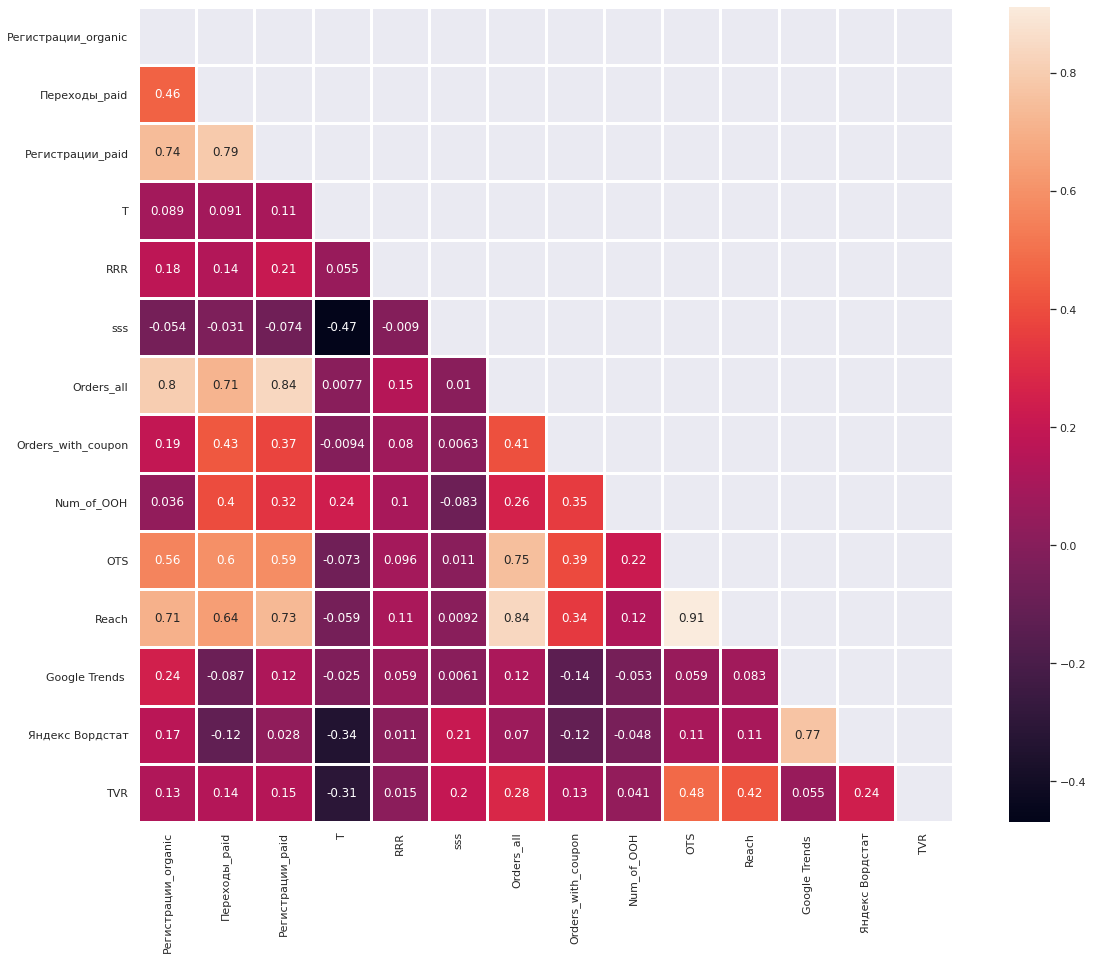

In [51]:
# матрица корреляции 
fig, ax = plt.subplots(figsize=(20, 15))
corr = data_for_model.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [57]:
with_reach = data_for_model.drop(['OTS'], axis=1)

In [58]:
with_ots = data_for_model.drop(['Reach'], axis=1)

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in data_for_model.columns:
    pct_missing = np.mean(data_for_model[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))


City - 0%
Date - 0%
Регистрации_organic - 0%
Переходы_paid - 0%
Регистрации_paid - 0%
T - 0%
RRR - 0%
sss - 0%
Orders_all - 0%
Orders_with_coupon - 0%
Num_of_OOH - 0%
OTS - 0%
Reach - 0%
Google Trends  - 3%
Яндекс Вордстат - 13%
TVR - 0%


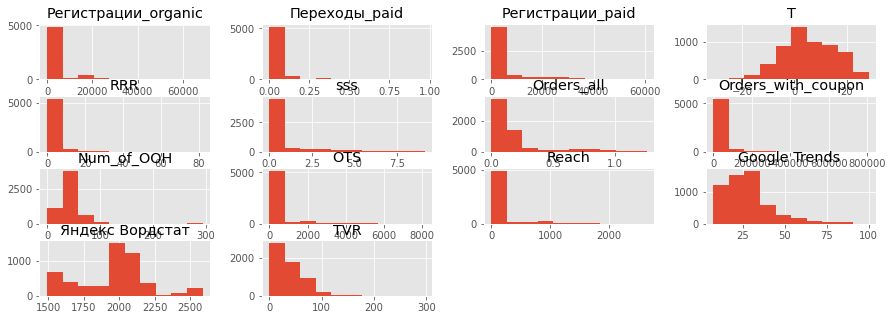

In [14]:

data_for_model.hist();

### А) сколько платежей в каждом городе принесла ТВ-кампания 

(с обоснованием валидности расчетов и оценкой качества модели)

<AxesSubplot:>

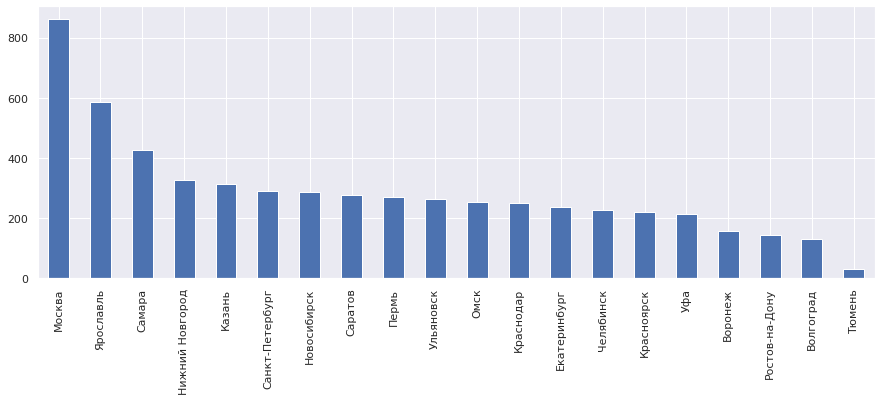

In [44]:
# Количество исследуемых дней по городам
data_for_model['City'].value_counts().plot.bar()

<AxesSubplot:xlabel='Date', ylabel='Density'>

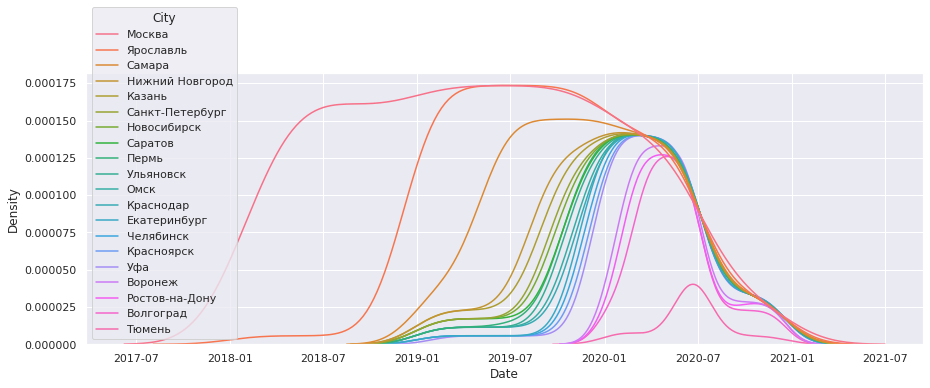

In [49]:
sns.kdeplot(data=data_for_model, x='Date', hue='City')

In [42]:
data_for_model['City'].value_counts()

Москва             861
Ярославль          587
Самара             427
Нижний Новгород    326
Казань             312
Санкт-Петербург    291
Новосибирск        285
Саратов            276
Пермь              270
Ульяновск          263
Омск               254
Краснодар          249
Екатеринбург       235
Челябинск          228
Красноярск         221
Уфа                214
Воронеж            158
Ростов-на-Дону     144
Волгоград          130
Тюмень              31
Name: City, dtype: int64

In [59]:

df = with_reach[data_for_model['City'] == 'Москва']

Text(0.5, 1.0, 'Заказы в Москве')

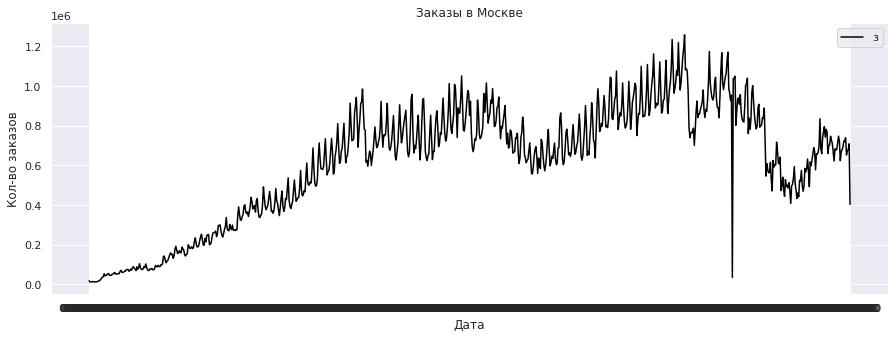

In [56]:

# Размещение заказов
x = df.Date
y = df.Orders_all
sns.lineplot(x=x, y=y, data=df, color='black')
plt.xticks(rotation=90)
plt.legend(loc='best',
           labels=('заказы в Москве за период'))

plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Заказы в Москве')

In [63]:
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [64]:
models = [LinearRegression(), # метод наименьших квадратов
              RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # случайный лес
              KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
              SVR(kernel='linear'), # метод опорных векторов с линейным ядром
              LogisticRegression() # логистическая регрессия
              ]

In [66]:
Xtrn, Ytrn  = train_test_split(df, test_size=0.4)

In [74]:
# временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
#получаем имя модели
    m = str(model)
    tmp['Model'] = m[:m.index('(')]    

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
with_reach.plot(ax=axes[0], kind='bar', title='with_reach')
with_ots.plot(ax=axes[1], kind='bar', color='green', title='with_ots')

<AxesSubplot:title={'center':'with_ots'}>